First we need to import a few modules: numpy, matplotlib, and h5py

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
# make graphics inline
%matplotlib inline

and define the output file, input files and parameters, such as energy, etc.

In [2]:
cxiFile = 'e1.cxi'

d = '../../data/d1/'
scanFile   = d + 'scan.npy'
objectFile = d + 'object.npy'
probeFile  = d + 'probe.npy'

energy     = 8000*1.60217657e-19 # 8 keV in J
pixel_size      =  55 * 1e-6 # 55 um pixels
real_pixel_size =  5.5 * 1e-9 # real space pixel size in m

wavelength = 1.98644e-25/energy

Load the probe file:

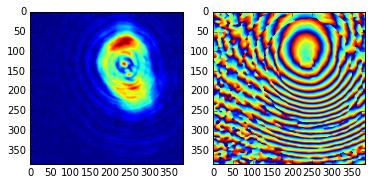

In [3]:
probe = np.load(probeFile) # (384, 384)

plt.subplot(1,2,1)
plt.imshow(abs(probe))
plt.subplot(1,2,2)
plt.imshow(np.angle(probe))

Define the size of the detector frame (assuming it is a square), calculate a distance to the detector, and define the position of the top left corner of the detector:

In [4]:
shape = probe.shape
det_side = shape[1] # Detector side in pixels

distance   = (det_side * pixel_size * real_pixel_size)/ wavelength

# required by the input file, but not used
corner_pos = [det_side/2*pixel_size,det_side/2*pixel_size,distance]

Load a file with a sequence of the scan x-y points and shift them into the positive plane: 

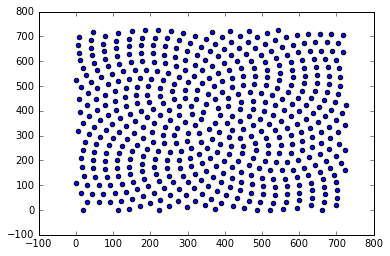

In [5]:
points  = np.load(scanFile)

Y = points[0] # [-363, 362]
X = points[1] # [-363, 363]

X -= min(X) 
Y -= min(Y)

pixel_translation = np.column_stack((X, Y, np.zeros(Y.size)))
real_translation = pixel_translation * real_pixel_size

plt.scatter(X, Y)
plt.show()

Load the object file:

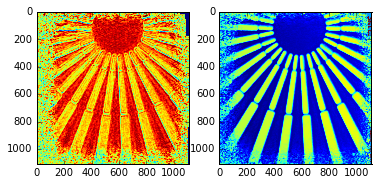

In [6]:
object = np.load(objectFile) # (1170, 1172)
object = object[0: object.shape[0] - 61, 62: object.shape[1]]

plt.subplot(1,2,1)
plt.imshow(abs(object))
plt.subplot(1,2,2)
plt.imshow(np.angle(object))

Now we can generate the detector frames from scan, object, and probe:

In [7]:
nframes = X.size

objFrames = np.empty((nframes,det_side,det_side), dtype = complex)
frames = np.empty((nframes,det_side,det_side))

for i in range(0,nframes):
    iy = int(pixel_translation[i,1])
    ix = int(pixel_translation[i,0])
    objFrames[i] = object[ iy : iy + det_side, ix : ix + det_side]
    frames[i] = np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(probe*objFrames[i]))))**2

Create the output file: 

In [8]:
f = h5py.File(cxiFile, "w")
f.create_dataset("cxi_version",data=140)
entry_1 = f.create_group("entry_1")

# 1. sample_1: name, geometry_1

sample_1   = entry_1.create_group("sample_1")

# 1.1 geometry_1: translation:

geometry_1 = sample_1.create_group("geometry_1")
geometry_1.create_dataset("translation", data=real_translation) # in meters

# 2. instrument_1: detector_1, source_1, data_1

instrument_1 = entry_1.create_group("instrument_1")

# 2.1 detector_1: distance, corner_position, x_pixel_size, y_pixel_size
# translation, data and axes, initial image

detector_1 = instrument_1.create_group("detector_1")
detector_1.create_dataset("distance", data=distance) # in meters
detector_1.create_dataset("corner_position", data=corner_pos) # in meters
detector_1.create_dataset("x_pixel_size", data=pixel_size) # in meters
detector_1.create_dataset("y_pixel_size", data=pixel_size) # in meters

detector_1["translation"] = h5py.SoftLink('/entry_1/sample_1/geometry_1/translation')

data = detector_1.create_dataset("data",data=frames)
data.attrs['axes'] = "translation:y:x"

detector_1.create_dataset("initial_image",data=object)

# 2.2 source_1: energy

source_1 = instrument_1.create_group("source_1")
source_1.create_dataset("energy", data=energy) # in J

source_1.create_dataset("probe",data=probe)

# 2.3 data_1: data, translationcd ..

data_1 = entry_1.create_group("data_1")

data_1["data"] = h5py.SoftLink('/entry_1/instrument_1/detector_1/data')
data_1["translation"] = h5py.SoftLink('/entry_1/sample_1/geometry_1/translation')

f.close()

In [9]:
# Try to reconstruct with
# sharp-nsls2.bin  -o 1 -i 100  e1.cxi
# show.py